## 노이즈가 포함된 시간-진동 데이터를 Python을 이용해 분석 하기.
진동 그래프에서 피크점 6개를 검출 후 그래프를 그린 후 피크점의 정보로 진동 분석  <br>  <br>
피크점 검출 후 피크점 데이터를 Code를 통해 계산하여 진동 분석

Problem : 데이터에 노이즈가 많아 scipy.signal의 find_peaks 함수로 피크점 정보를 추출할 수 없음  <br>
Solution : 노이즈 진폭으로 인한 피크점들을 제거하기 위해 하나의 양수~음수 구간을 찾아 최대값을 피크점으로 처리

Comparison : 대부분은 CSV데이터에서 수작업으로 피크점을 찾고 결과 계산을 했음.

Top 6 peak points:
1. t=0.016, x=24.4
2. t=0.047, x=21.2
3. t=0.081, x=20.8
4. t=0.116, x=19.2
5. t=0.147, x=17.2
6. t=0.181, x=17.2


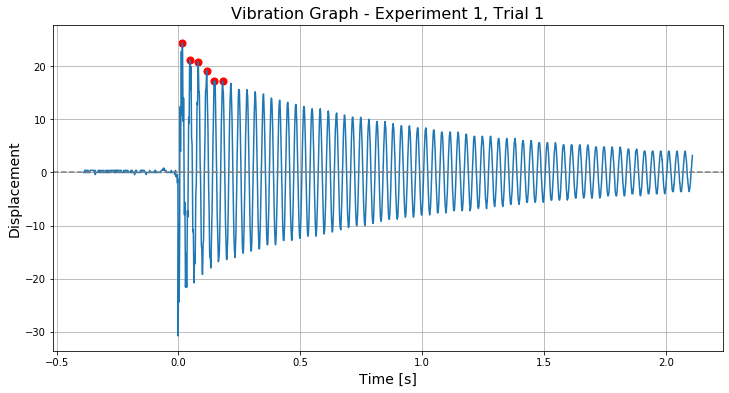

In [1]:
# 실험 그래프 그리기 및 피크점 정보 추출

import pandas as pd
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# csv 파일 불러오기
df = pd.read_csv("data/F0000CH1.CSV")

# 데이터에서 시간열(t)과 변위열(x) 추출
t = df.iloc[:, 3]
x = df.iloc[:, 4]

# 전체 시간 범위 설정
t_total = t.iloc[-1]

# 그래프 출력
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, x)
plt.title("Vibration Graph - Experiment 1, Trial 1", fontsize=16)
ax.set_xlabel("Time [s]", fontsize=14)
ax.set_ylabel("Displacement", fontsize=14)

# 피크 검출 조건 수정: 양수 음수 구간을 찾아서 최대값을 피크로 간주
new_peaks = []
start = 0
for i in range(len(x) - 1):
    if x[i] < 0 and x[i + 1] >= 0:
        end = i
        peak_idx = start + x[start:end].argmax()
        if t[peak_idx] > 0:  # t > 0 조건 추가
            new_peaks.append(peak_idx)
        start = i

# 상위 6개 피크값만 추출
num_peaks = 6
peaks = sorted(new_peaks)[:num_peaks]

# 피크값에 해당하는 점을 그래프 위에 표시
ax.scatter(t[peaks], x[peaks], s=50, marker="o", color="red")

# 그래프에 0에 대한 grid 추가
plt.axhline(y=0, color="gray", linestyle="--")
plt.grid()

# 상위 6개 피크값 출력
print("Top 6 peak points:")
for i, peak in enumerate(peaks):
    print(f"{i+1}. t={t[peak]}, x={x[peak]}")

plt.show()

In [3]:
# 피크점 정보를 통한 진동 분석

import numpy as np

# 피크점 6개 선택
k_eq = 405.0926

t1, t2, t3 = t[peaks[0]], t[peaks[1]], t[peaks[2]]
t4, t5, t6 = t[peaks[3]], t[peaks[4]], t[peaks[5]]

x1, x2, x3 = x[peaks[0]], x[peaks[1]], x[peaks[2]]
x4, x5, x6 = t[peaks[3]], x[peaks[4]], x[peaks[5]]

# 감쇠비, 고유주파수 5개 값 구하기
delta1 = np.log(x1/x2)
zeta1 = delta1/np.sqrt((2*np.pi)**2 + delta1**2)
w_d1 = 2*np.pi/(t2-t1)
w_n1 = w_d1/(np.sqrt(1-(zeta1)**2))

delta2 = np.log(x2/x3)
zeta2 = delta2/np.sqrt((2*np.pi)**2 + delta2**2)
w_d2 = 2*np.pi/(t3-t2)
w_n2 = w_d2/(np.sqrt(1-(zeta2)**2))

delta3 = np.log(x3/x4)
zeta3 = delta3/np.sqrt((2*np.pi)**2 + delta3**2)
w_d3 = 2*np.pi/(t4-t3)
w_n3 = w_d3/(np.sqrt(1-(zeta3)**2))

delta4 = np.log(x4/x5)
zeta4 = delta4/np.sqrt((2*np.pi)**2 + delta4**2)
w_d4 = 2*np.pi/(t5-t4)
w_n4 = w_d4/(np.sqrt(1-(zeta4)**2))

delta5 = np.log(x5/x6)
zeta5 = delta5/np.sqrt((2*np.pi)**2 + delta5**2)
w_d5 = 2*np.pi/(t6-t5)
w_n5 = w_d5/(np.sqrt(1-(zeta5)**2))

print(f"T_d: {t2-t1:.3f}, {t3-t2:.3f}, {t4-t3:.3f}, {t5-t4:.3f}, {t6-t5:.3f}")
print(f"delta: {delta1:.4f}, {delta2:.4f}, {delta3:.4f}, {delta4:.4f}, {delta5:.4f}")
print(f"zeta: {zeta1:.4f}, {zeta2:.4f}, {zeta3:.4f}, {zeta4:.4f}, {zeta5:.4f}")
print(f"w_d: {w_d1:.4f}, {w_d2:.4f}, {w_d3:.4f}, {w_d4:.4f}, {w_d5:.4f}")
print(f"w_n: : {w_n1:.4f}, {w_n2:.4f}, {w_n3:.4f}, {w_n4:.4f}, {w_n5:.4f}")

# 5가지의 평균값으로 고유주파수, 감쇠비, 등가 질량, 등가 감쇠 계수 구하기
w_n = (w_n1+w_n2+w_n3+w_n4+w_n5)/5
zeta = (zeta1+zeta2+zeta3+zeta4+zeta5)/5
m_eq = k_eq/w_n**2
c_eq = 2*zeta*(np.sqrt(m_eq*k_eq))

print(f"고유주파수: {w_n:.4f}")
print(f"감쇠비: {zeta:.4f}")
print(f"등가 질량: {m_eq:.4f}")
print(f"등가 감쇠계수: : {c_eq:.4f}")

T_d: 0.031, 0.034, 0.035, 0.031, 0.034
delta: 0.1406, 0.0190, 5.1891, -4.9991, 0.0000
zeta: 0.0224, 0.0030, 0.6368, -0.6226, 0.0000
w_d: 202.6834, 184.7996, 179.5196, 202.6834, 184.7996
w_n: : 202.7341, 184.8004, 232.8271, 259.0087, 184.7996
고유주파수: 212.8340
감쇠비: 0.0079
등가 질량: 0.0089
등가 감쇠계수: : 0.0301


실험 데이터(오실로스코프 전압 데이터)가 변위 정보라는 것에 대한 확인  <br>
가속도 데이터라고 가정 하고 적분하여 확인해보는 과정.

Top 6 peak points:


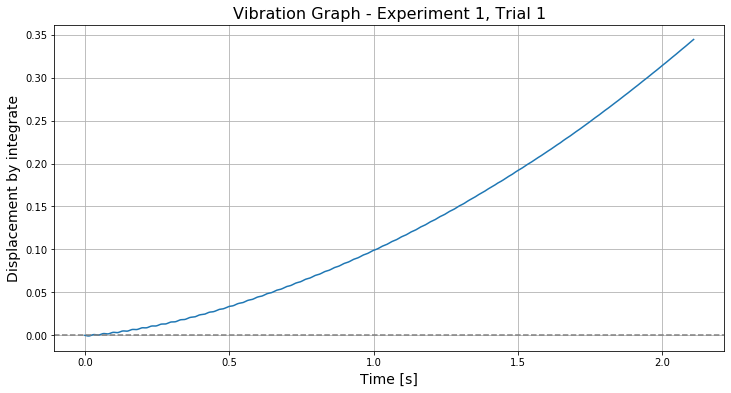

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# csv 파일 불러오기
df = pd.read_csv("F0000CH1.CSV")

# 데이터에서 시간열(t)과 변위열(x) 추출
t = df.iloc[:, 3]
a = df.iloc[:, 4]

# t>=0 범위에서 데이터 추출
t_positive = t[t >= 0]
a_positive = a[t >= 0]

# 전체 시간 범위 설정
t_total = t_positive.iloc[-1]

t = t_positive

# 가속도를 적분하여 속도(v) 계산
v = (a_positive * 0.001).cumsum()

# 속도를 다시 적분하여 변위(x) 계산
x = (v * 0.001).cumsum()

# 그래프 출력
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, x)
plt.title("Vibration Graph - Experiment 1, Trial 1", fontsize=16)
ax.set_xlabel("Time [s]", fontsize=14)
ax.set_ylabel("Displacement by integrate", fontsize=14)


# 그래프에 0에 대한 grid 추가
plt.axhline(y=0, color="gray", linestyle="--")
plt.grid()

# 상위 6개 피크값 출력
print("Top 6 peak points:")
for i, peak in enumerate(peaks):
    print(f"{i+1}. t={t[peak]}, x={x[peak]}")

plt.show()